# Predictive HW4-Q2 Cats VS Dogs.


#### Connecting to Kaggle API to import the data for Cats vs Dogs Competition

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anirudhmittalcarlson","key":"1b664cc9227fc4d8586de7038714a3e7"}'}

In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

In [ ]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

#### Unzipping test and training datasets

In [ ]:
!unzip test.zip

In [ ]:

!unzip train.zip

In [ ]:

import os, cv2, random
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split

## Importing the Train Data

In [ ]:
filenames = os.listdir("../content/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df = df.reset_index(drop=True)

In [8]:
df.head()

,filename,category
0,dog.8619.jpg,1
1,cat.9987.jpg,0
2,dog.1018.jpg,1
3,dog.1678.jpg,1
4,cat.2263.jpg,0


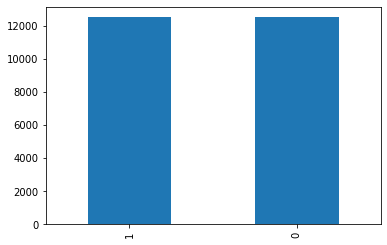

In [9]:
df['category'].value_counts().plot.bar()

The Cats and dogs have an equal split

## Sample Image


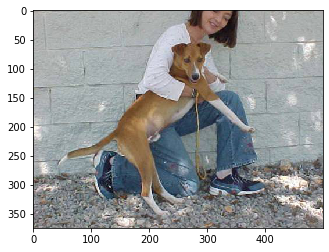

In [97]:
sample = random.choice(filenames)
image = load_img("../content/train/"+sample)
plt.imshow(image)

##Divinding the data into test and validation

In [ ]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
train_df, validation_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

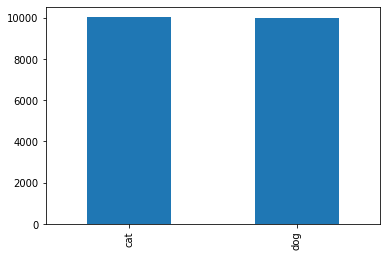

In [73]:
train_df['category'].value_counts().plot.bar()

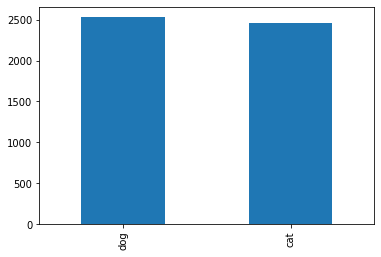

In [74]:

validation_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validation_df.shape[0]
batch_size=15

Generating new images using a Image Generator. This i sdone to increase the number of images in the training set to train our model on more data.

In [115]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)



train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


The validation set is converted into the vector to be fed into the model.

In [116]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    validation_df, 
    "../content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## Model Building

 We are using Keras Sequential model to build our Neural Netowrk. We use a pretrained VGG16 with imagemet weights to train our NN, then 3 Dense layers are added to the model.
 Finally we use a sigmoid output layer to get the probabilities of our predictions.

In [117]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
clss = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
clss = Dense(512, activation='relu')(clss)
# Add a dropout rate of 0.5
clss = Dropout(0.5)(cls)
# Addling a dense layer
clss = Dense(512, activation='relu')(clss)

# Addling a dense layer
clss = Dense(512, activation='relu')(clss)
# Add a final sigmoid layer for classification
clss= layers.Dense(1, activation='sigmoid')(clss)

model = Model(pre_trained_model.input, clss)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

Here we fit the training data into the prepared model and we use the validation dataset to validate our predictions for each epoch.
Here callbacks are also defined and used to stop the epoch early when the learning rates stagnents.

In [118]:
history = model.fit_generator(
    train_generator, 
    epochs=12,
    validation_data=val_generator,
    validation_steps=total_validate/batch_size, # test_dataset.shape[0]//20,
    steps_per_epoch=total_train/batch_size, # training_dataset.shape[0]//20,
    callbacks=callbacks
)

Epoch 1/12
1250/1250 [==============================] - 264s 211ms/step - loss: 0.3917 - acc: 0.8084 - val_loss: 0.1494 - val_acc: 0.9386
Epoch 2/12
1250/1250 [==============================] - 246s 197ms/step - loss: 0.1750 - acc: 0.9278 - val_loss: 0.1119 - val_acc: 0.9542
Epoch 3/12
1250/1250 [==============================] - 246s 197ms/step - loss: 0.1398 - acc: 0.9422 - val_loss: 0.0990 - val_acc: 0.9600
Epoch 4/12
1250/1250 [==============================] - 246s 197ms/step - loss: 0.1205 - acc: 0.9506 - val_loss: 0.0911 - val_acc: 0.9650
Epoch 5/12
1250/1250 [==============================] - 247s 198ms/step - loss: 0.1098 - acc: 0.9546 - val_loss: 0.0847 - val_acc: 0.9674
Epoch 6/12
1250/1250 [==============================] - 245s 196ms/step - loss: 0.1059 - acc: 0.9568 - val_loss: 0.0861 - val_acc: 0.9656
Epoch 7/12
1250/1250 [==============================] - 246s 197ms/step - loss: 0.0932 - acc: 0.9623 - val_loss: 0.0747 - val_acc: 0.9716
Epoch 8/12
1250/1250 [============

###Importing and Converting the Test Data

In [ ]:
filenames = os.listdir("../content/test")

df_test_final = pd.DataFrame({
    'filename': filenames
})
df_test_final = df_test_final.reset_index(drop=True)

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    df_test_final, 
    "../content/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


## Predicting the probabilities of the test images

In [ ]:
prediction_probabilities = model.predict(test_generator, verbose=1)

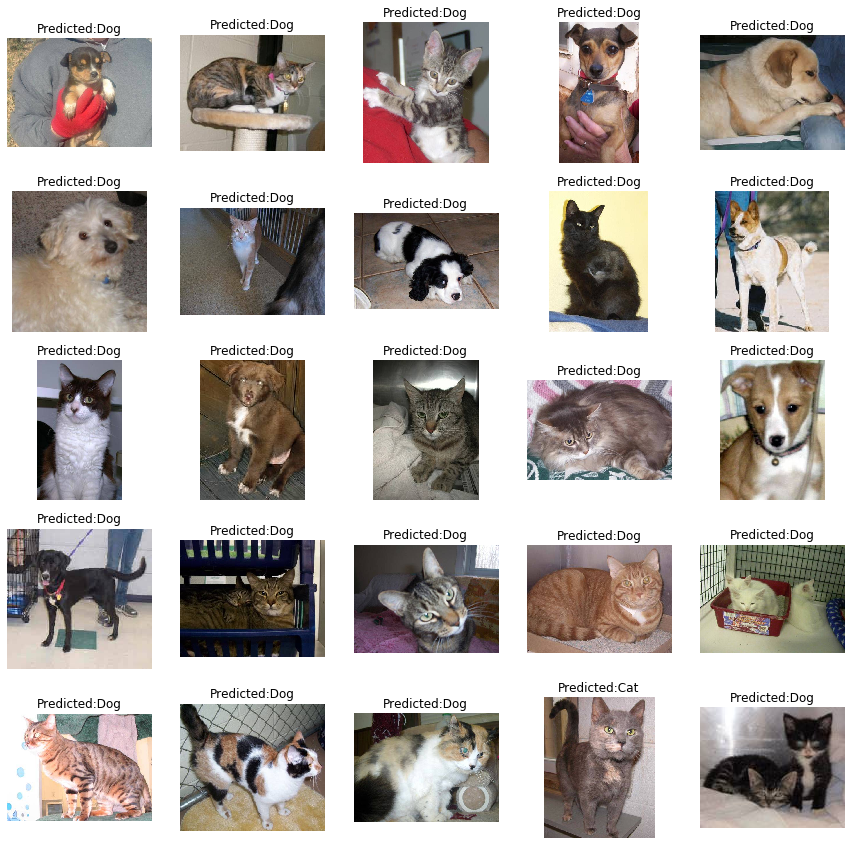

In [132]:
import cv2 
TEST_DIR = "../content/test/"
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "Dog" if prediction_probabilities[i] else "Cat"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()

## Creating a final submission file to be submitted on kaggle

In [ ]:
submission = df_test_final.copy()
submission['id'] = submission['filename'].str.split('.').str[0]
submission['label'] = pd.DataFrame(prediction_probabilities)[0]
submission.drop(['filename'], axis=1, inplace=True)
submission.to_csv('submission_VGG.csv', index=False)

### The final log(loss) of the model .13120

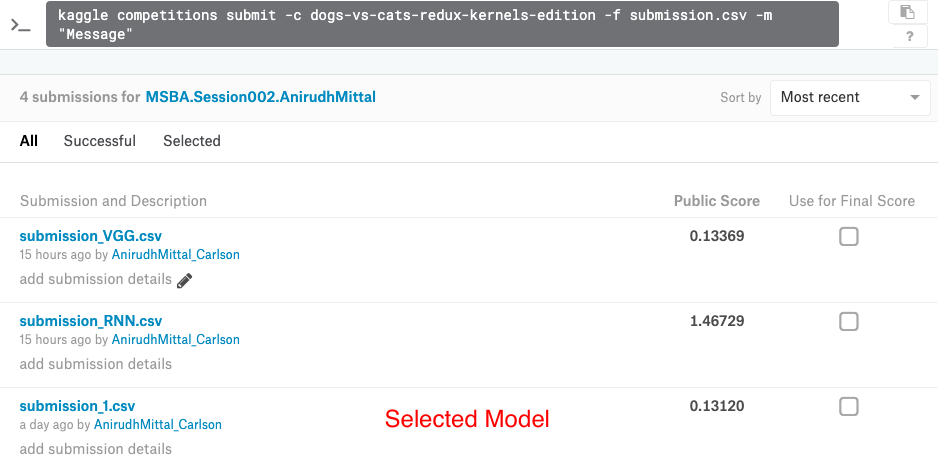

In [23]:
image_path = 'kaggle_sub.png'
from IPython.display import display, Image
display(Image(filename= image_path))

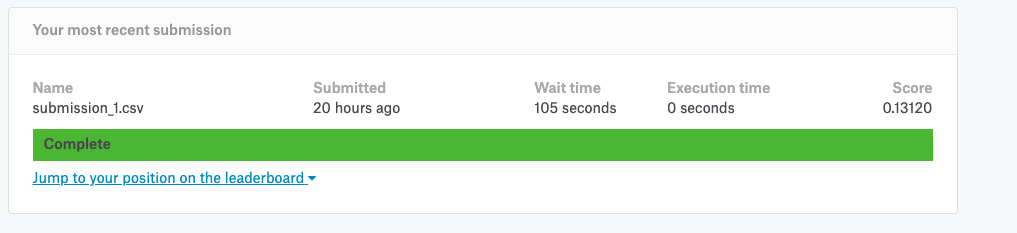

In [26]:
image_path = 'kaggle_error.png'
from IPython.display import display, Image
display(Image(filename= image_path))